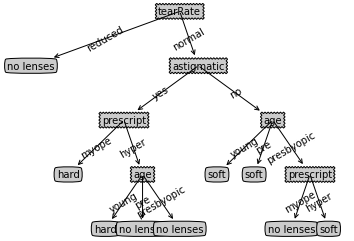

实力良好


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Title : 使用决策树预测隐形眼镜类型
# Description :隐形眼镜数据是非常著名的数据集 ，它包含很多患者眼部状况的观察条件以及医生推荐的隐形眼镜类型 。
# 隐形眼镜类型包括硬材质 、软材质以及不适合佩戴隐形眼镜 。数据来源于UCI数据库
# 为了更容易显示数据,本书对数据做了简单的更改 ，数据存储在源代码下载路径的文本文件中 。

# 本节我们将通过一个例子讲解决策树如何预测患者需要佩戴的隐形眼镜类型。
# 使用小数据集 ，我们就可以利用决策树学到很多知识：眼科医生是如何判断患者需要佩戴的镜片类型；
# 一旦 理解了决策树的工作原理，我们甚至也可以帮助人们判断需要佩戴的镜片类型。
from math import log
import operator
import matplotlib.pyplot as plt


# 计算数据集的香农熵
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:     # 为所有可能分类创建字典
        currentLabel = featVec[-1]  # 取数据集的标签
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0           # 分类标签值初始化
        labelCounts[currentLabel] += 1  # 给标签赋值
    shannonEnt = 0.0                    # 熵初始化
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries       # 求得每个标签的概率     # L(Xi) = -log2P(Xi)
        shannonEnt -= prob * log(prob, 2)   # 以2为底求对数      # H = - Σi=1 n  P(Xi)*log2P(Xi)
        # 注意这里是-= 虽然是求和 但是求和值<0 所以这里-=
    return shannonEnt


# 按照给定特征划分数据集
def splitDataSet(dataSet, axis, value):
    # (待划分的数据集、划分数据集的特征索引、特征的返回值)
    # 该函数是为了将划分的左右提取出来
    retDataSet = []
    for featVec in dataSet:
        # print("1",featVec)
        if featVec[axis] == value:
            # print("2",featVec[axis])
            reducedFeatVec = featVec[:axis]
            # print("3",reducedFeatVec)
            reducedFeatVec.extend(featVec[axis+1:])
            # print("4",reducedFeatVec)
            retDataSet.append(reducedFeatVec)
            # print("5",retDataSet)
    return retDataSet


# 选择最好的数据集划分方式
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1      # 计算特征的数目
    baseEntropy = calcShannonEnt(dataSet)   # 计算数据集的原始香农熵 用于与划分完的数据集的香农熵进行比较
    bestInfoGain = 0.0                      # 最佳信息增益初始化
    bestFeature = -1                        # 最佳划分特征初始化 TheBestFeatureToSplit
    for i in range(numFeatures):        # 遍历所有的特征
        featList = [example[i] for example in dataSet]  # 使用列表推导式创建列表 用于储存每一个数据的第i个特征
        # [ 表达式 for 变量 in 序列或迭代对象 ]             在这里的执行效果就是 每一列的特征都提取出来
        # aList = [ x ** 2 for x in range(10) ]
        # >>>aList  [0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
        uniqueVals = set(featList)       # 特征去重
        newEntropy = 0.0                 # 划分后信息熵初始化
        for value in uniqueVals:        # 遍历去重后的特征  分别计算每一个划分后的香农熵
            subDataSet = splitDataSet(dataSet, i, value)       # 划分
            prob = len(subDataSet)/float(len(dataSet))        # 算概率
            newEntropy += prob * calcShannonEnt(subDataSet)   # 算熵
        infoGain = baseEntropy - newEntropy     # 计算信息增益
        if (infoGain > bestInfoGain):       # 比较划分后的数据集的信息增益是否大于0 大于0 证明划分的有效
            bestInfoGain = infoGain         # 储存最佳信息增益值
            bestFeature = i                 # 储存最佳特征值索引
    return bestFeature                      # 返回最佳特征值索引


"""
函数名称：majorityCnt（）
函数说明：统计classList中出现次数最多的元素（类标签）与K-近邻邻近K个元素排序函数功能一致
背景：如果数据集已经处理了所有属性，但是类标签依然不是唯一的
此时我们需要决定如何定义该叶子节点，在这种情况下，我们通常会采用多数表决的方法决定该叶子节点的分类。
Parameters：
    classList：类标签列表
Returns：
    sortedClassCount[0][0]：出现次数最多的元素（类标签）
"""
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]


"""
    函数名称：createTree（）
    函数说明：
        递归构建决策树
        对算法步骤和具体递归赋值操作要多注意
    parameters:
        dataSet:数据集
        labels:分类属性标签
    returns：
        myTres：决策树
"""
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):  # ["yes","yes"]
        return classList[0]     # 结束划分 如果只有一种分类属性  属性标签重复
    if len(dataSet[0]) == 1:    # 结束划分 如果没有更多的特征了  都为同一类属性标签了
        return majorityCnt(classList)   # 计数排序 取最大数特征
    bestFeat = chooseBestFeatureToSplit(dataSet)    # 获取最优特征索引
    bestFeatLabel = labels[bestFeat]                # 获取最优特征属性标签
    myTree = {bestFeatLabel: {}}                    # 决策树初始化 嵌套字典
    # print("0tree", myTree)
    del(labels[bestFeat])                           # 删除已经使用的特征标签 这时应只剩下有脚蹼特征了
    featValues = [example[bestFeat] for example in dataSet]     # 取出数据集所有最优属性值
    uniqueVals = set(featValues)                                 # 去重
    # print("标签%s,标签值%s" % (bestFeatLabel, uniqueVals))
    # 开始构建决策树
    for value in uniqueVals:
        subLabels = labels[:]   # 得到剩下的所有特征标签 作为我们的子节点可用
        # print("1tree", myTree)
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
        # 对no surfacing特征 值为1时的赋值是最后一次filppers特征全部分类完毕后
        # 才将整个filppers的字典值给了关键字1
        #     abc = {"s":{}}
        #     abc["s"][0] = "2"
        #     print(abc)        {'s': {0: '2'}}
        # print("2tree", myTree)
    return myTree


"""
    函数说明：
        得到树的叶子结点个数
        绘制一棵完整的树需要一些技巧。我们虽然有x、y坐标，但是如何放置所有的树节点却是个问题。
        我们必须知道有多少个叶节点，以便可以正确确定x轴的长度.
    Parameters：
        myTree：决策树
    Return:
        numLeafs:叶子结点个数
"""
def getNumLeafs(myTree):
    numLeafs = 0        # 结点数目初始化
    # firstStr = myTree.keys()[0]
    # TypeError: 'dict_keys' object does not support indexing
    # 原因：这是由于python3.6版本改进引起的。
    # 解决方案：
    # temp_keys = list(myTree.keys())
    # firstStr = temp_keys[0]
    # 在这里 只能取到第一个Key值 其他的key值嵌套在字典里 该方法识别不了 不过正是我们想要的
    temp_keys = list(myTree.keys()) # mytree: {'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
    firstStr = temp_keys[0]     # 这里我们取到决策树的第一个key值
    secondDict = myTree[firstStr]   # 由于树的嵌套字典格式 我们通过第一个key得到了其value部分的另一个字典
    for key in secondDict.keys():   # 取出第二字典的key 0和1
        if type(secondDict[key]).__name__ == 'dict':
            # 判断是否相应key的value是不是字典 是字典就不是叶子结点
            # 继续调用本函数拆分该字典直到不是字典 即为叶子结点 进行记录
            numLeafs += getNumLeafs(secondDict[key])
        else:   # 不是字典直接记录为叶子结点
            numLeafs += 1
    return numLeafs

"""
    函数说明：
        得到树的深度
        我们还需要确定树的深度，以便于确定y轴的高度
    Parameters：
        myTree：决策树
    Return:
        maxDepth：树高
"""
def getTreeDepth(myTree):
    maxDepth = 0
    # firstStr = myTree.keys()[0]
    firstStr = next(iter(myTree))   # 这里有第二种方法可以取到到第一个key值
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            # 与记录叶子结点数目类似 一个字典算是一层的代表（因为字典必有分支）
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            # 是叶子结点也给他记作一层 但是要注意 当同一层不单单只是叶子结点 有下层分支时
            # 会将本来有两层的计数重置为一层 为了避免这一错误 我们有了下面的if判断
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

"""
    函数说明：
        模拟树的创建（自定义的方式）
        为了避免每次调用都要通过数据集创建树的麻烦
    Parameters：
        i:哪个树
        我们可以多模拟几个数来检测函数的可行性
    Return:
        listOfTrees[i]：第i个树
"""
def retrieveTree(i):
    listOfTrees = [{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                   {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                   ]
    return listOfTrees[i]


decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

"""
    函数说明：
        使用文本注解绘制树节点
    parameters：
        nodeTxt：注释文段
        centerPt：文本中心坐标
        parentPt：箭头尾部坐标
        nodeType：注释文本类型
    Return：
        无返回 执行annotate（）画布

"""
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )

"""
    函数说明：
        在父子结点间填充文本信息
    Parameters：
        cntrPt，parentPt：用于计算标注位置（我们取父子连线的中点作为标注位置）
        txtString:标注内容
    Return:
        None
"""
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    # (parentPt[0]+cntrPt[0])/2.0 考虑：
    # 这次案例中 发现两个公式的树画出来的是相互对称的
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)


"""
    函数说明：
        绘制决策树---筹备
    Parameters：
        myTree:决策树
        parentPt：父节点位置（在上节中是箭头尾部 箭头头部是子节点）父节点----->子节点
        nodeTxt：标注信息
    Special:
        numLeafs:当前结点的叶子节点数（是在变的）
        tatalW:树的总叶子数
    Return:
        None
"""
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)  # 得到叶子结点计算树的宽度
    depth = getTreeDepth(myTree)    # 得到树深度
    firstStr = list(myTree.keys())[0]     # 得到根结点（父节点）注释内容
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)# 根节点位置
    # 第一次看非常之疑惑 plotTree.xOff、plotTree.totalW、plotTree.yOff 三个突兀的东西就这样出现了
    # 一开始以为是定义函数对象的调用 又想了想不太对劲 自己调用自己啥的也没有对三变量定义的过程啊 还是重复这样
    # 搜了很多没发现什么雷同的 看书上解释是一种全局变量 但还是不理解  毕竟是第一次见
    # 换了个方向搜索 仍然无果而终 最后用type（）检测变量 的确是个变量 好吧 难受的心路历程
    # 由于按顺序去看的函数没有先看下面的执行函数 发现 执行函数中确实有提前定义这几个变量 全局变量石锤
    # 现在唯一的疑惑就是 为什么可以这样定义？有什么意义？
    # 猜测：由于执行函数会调用多个函数来实现总的绘图 所以我们需要用函数名.变量 这样的形式来区分应用于哪个函数
    # 当然这种变量也可以放在需求函数里面定义 但是由于此处变量需要inTree变量来计算值所以就干脆放在执行函数里面了
    # 执行函数的参数恰好就是inTree （图个方便？）
    # 巧妙的分析一波  哈哈啊哈哈
    plotMidText(cntrPt, parentPt, nodeTxt)  # 画连线标注
    plotNode(firstStr, cntrPt, parentPt, decisionNode)  # 画结点 画线
    secondDict = myTree[firstStr]   # 解析下一个字典（根节点）/叶子
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD     # 计算下一个结点的y
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':    # 子树
            plotTree(secondDict[key], cntrPt, str(key))
        else:   # 叶子节点
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
    # 递归完后需要回退到上层，绘制当前树根节点的其他分支节点。


"""
    函数说明：
       绘制决策树---执行
    Parameters：
        inTree:决策树
    Return:
        None 展示画布
"""
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])    # 定义x，y轴为空 为后面不显示轴作准备
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    # 传入刚才定义参数 构造子图
    # createPlot.ax1 = plt.subplot(111, frameon=False) # 有轴的
    plotTree.totalW = float(getNumLeafs(inTree))
    # tatalW:树的宽度初始化 = 叶子节点
    plotTree.totalD = float(getTreeDepth(inTree))
    # tatalD:树的深度 = 树高
    plotTree.xOff = -0.5/plotTree.totalW    # 为开始x位置为第一个表格左边的半个表格距离位置
    plotTree.yOff = 1.0     # y位置1
    # 使用两个全局变量plotTree.xOff、plotTree.yOff追踪已经绘制的节点位置
    # 这部分代码直接去看很难理解 之后会有注解
    plotTree(inTree, (0.5, 1.0), '')    # 调用函数开始绘图 一开始标注为空 因为第一个就是根结点
    plt.show()


def prodict():
    # str通过encode()方法可以编码为指定的bytes；
    # 反过来，如果我们从网络或磁盘上读取了字节流，那么读到的数据就是bytes。要把bytes变为str，就需要用decode()方法
    # 这里读文件读到的是字节 需要转化为str
    with open("lenses.txt", "rb") as fr:    # 取出数据集
        lenses = [inst.decode().strip().split('\t')for inst in fr.readlines()]
        # 解析由tap键分割的数据 去除数据左右的空格
        # 这里强调一下  决策树的数据集是由 特征属性值和分类标签两部分组成的
    lensesLabels = ['age', 'prescript', 'astigmatic', "tearRate"]    # 设置特征属性
    lensesTree = createTree(lenses, lensesLabels)                       # 创造样本决策树(分类器)
    createPlot(lensesTree)
    return lensesTree# , lensesLabels

"""
函数说明：
    对决策树进行分类
Parameters：
    inputTree：决策树
    featLabels：数据集中label顺序列表
    testVec：两个特征的属性值[特征一，特征二]
Rertun:
    classLabel：预测结果
    根据两个特征的属性值来预测分类
"""
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]    # 得到首key值
    secondDict = inputTree[firstStr]        # 首key的value--->下一个分支
    featIndex = featLabels.index(firstStr)  # 确定根节点是标签向量中的哪一个（索引）
    key = testVec[featIndex]                # 确定一个条件后的类别或进入下一个分支有待继续判别
    # 这里要注意  我们并不知道目前的这个结点（也就是特征）在数据集中的具体位置 [0,1,no]
    # 是第一个 还是第二个 所以需要用具体值再找索引的方式
    # 找到了索引之后 我们就可以确定他是数据集中的哪一个值
    # （这里再强调一下 数据集中特征的属性值的顺序 与 标签向量label中特征的顺序是一致的）
    # dataSet = [[1, 1, 'yes']]
    # labels = ['no surfacing', 'flippers']
    # 这样一来计算机就知道了该在你放入的测试数据集寻找哪一个作为当前节点的预测值了
    # 我们又用该索引去查找测试列表处该结点给的预测值是0还是1
    # 是0相当于找了no预测值 是1 证明还需要判断或者是yes预测值
    valueOfFeat = secondDict[key]
    if isinstance(valueOfFeat, dict): # 判断实例函数 和 type函数类似 但是这个更好一点
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else:
        classLabel = valueOfFeat
    return classLabel


if __name__ == "__main__":
    # mytree, labels = prodict()    这里返回的标签不完整 因为之前调用createTree（）时 取最优特征后删除了它在列表中的存在
    # 另外 只要一个返回值就删除另一个 不然只接受一个返回值
    # 计算机会将返回值变成元组类型 会在其他函数中需求取到列表的key值的时候 产生不必要的麻烦
    mytree = prodict()
    labels = ['age', 'prescript', 'astigmatic', "tearRate"]
    result = classify(mytree, labels, ["presbyopic", "hyper", "yes", "normal"])
    if result == 'no lenses':
        print("实力良好")
    if result == 'soft':
        print("轻微近视")
    if result == 'hard':
        print("重度近视")
	    # >>>视力良好